In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt


# Definicja sieci neuronowej do upscalingu
class SuperResolutionNet(nn.Module):
    def __init__(self):
        super(SuperResolutionNet, self).__init__()

        # Pierwsza warstwa - ekspansja kanałów
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4), nn.ReLU(inplace=True)
        )

        # Warstwy rezydualne
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(5)])

        # Warstwa po blokach rezydualnych
        self.after_residual = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64)
        )

        # Warstwy upsamplujące (64->128->256)
        self.upsample = nn.Sequential(UpsampleBlock(64, 128), UpsampleBlock(128, 256))

        # Warstwa końcowa - redukcja do 3 kanałów (RGB)
        self.final = nn.Conv2d(256, 3, kernel_size=9, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        residual = self.residual_blocks(initial)
        after_res = self.after_residual(residual)
        features = torch.add(initial, after_res)
        upsampled = self.upsample(features)
        output = self.final(upsampled)
        return torch.tanh(output)  # Ograniczenie wartości do zakresu [-1,1]


# Blok rezydualny
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = torch.add(out, residual)
        return out


# Blok upsamplujący (implementacja PixelShuffle)
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)  # Zwiększa rozdzielczość 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.relu(x)
        return x


class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, transform_hr=None, transform_lr=None):
        """
        Inicjalizuje dataset.
        :param hr_dir: Ścieżka do folderu z obrazami wysokiej rozdzielczości (HR).
        :param transform_hr: Transformacje do obrazów wysokiej rozdzielczości.
        :param transform_lr: Transformacje do obrazów niskiej rozdzielczości.
        """
        self.hr_dir = hr_dir
        # Lista plików w katalogu HR (teraz nie ładujemy ich od razu do pamięci)
        self.image_files = sorted(
            [f for f in os.listdir(hr_dir) if os.path.isfile(os.path.join(hr_dir, f))][
                0:5
            ]
        )  # Ograniczenie liczby obrazów do 100
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr

    def __len__(self):
        """
        Zwraca liczbę dostępnych próbek w zbiorze danych.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Ładuje i przetwarza obraz na żądanie (lazy loading).
        :param idx: Indeks próbki.
        :return: Obraz w niskiej rozdzielczości i wysokiej rozdzielczości.
        """
        img_name = self.image_files[idx]
        img_path = os.path.join(self.hr_dir, img_name)

        # Lazy loading: Wczytanie obrazu HR tylko wtedy, gdy jest potrzebny
        hr_image = Image.open(img_path).convert("RGB")

        # Transformacje obrazu HR (jeśli zostały podane)
        if self.transform_hr:
            hr_image = self.transform_hr(hr_image)

        # Tworzymy obraz LR poprzez zmianę rozmiaru HR (pomijamy wcześniejsze wczytanie LR)
        lr_image = transforms.Resize((64, 64))(hr_image)

        # Transformacje obrazu LR (jeśli zostały podane)
        if self.transform_lr:
            lr_image = self.transform_lr(lr_image)

        return lr_image, hr_image


# Funkcja treningu sieci
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device="cuda"):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (lr_images, hr_images) in enumerate(train_loader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Zerowanie gradientów
            optimizer.zero_grad()

            # Forward pass
            outputs = model(lr_images)

            # Obliczenie straty
            loss = criterion(outputs, hr_images)

            # Backward pass i optymalizacja
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}"
                )

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Zapis modelu co 10 epok
        if (epoch + 1) % 10 == 0:
            torch.save(
                model.state_dict(), f"super_resolution_model_epoch_{epoch + 1}.pth"
            )

    return model


# Funkcja do wizualizacji wyników
def visualize_results(model, test_image_path, device="cuda"):
    model.eval()
    model.to(device)

    # Wczytanie obrazu testowego
    test_image = Image.open(test_image_path).convert("RGB")
    test_transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )

    lr_image = test_transform(test_image).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image = model(lr_image)

    # Przywrócenie danych obrazu do zakresu [0,1]
    sr_image = (sr_image + 1) / 2.0
    lr_image = (lr_image + 1) / 2.0

    # Konwersja do formatu numpy do wyświetlenia
    sr_image = sr_image.squeeze().permute(1, 2, 0).cpu().numpy()
    lr_image = lr_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Wczytanie oryginalnego obrazu o wysokiej rozdzielczości do porównania
    hr_image = transforms.Resize((256, 256))(test_image)
    hr_image = transforms.ToTensor()(hr_image).permute(1, 2, 0).numpy()

    # Wyświetlenie obrazów
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title("Niska rozdzielczość (64x64)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(sr_image)
    plt.title("Upscaling przez sieć (256x256)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title("Oryginalna wysoka rozdzielczość (256x256)")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig("super_resolution_results.png")
    plt.show()


# Parametry
hr_dir = "images_256"
batch_size = 64
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformacje dla obrazów o wysokiej rozdzielczości
transform_hr = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Zapewnienie jednolitego rozmiaru
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Transformacje dla obrazów o niskiej rozdzielczości
transform_lr = transforms.Compose(
    [transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)

# Stworzenie zbioru danych i data loadera
dataset = SuperResolutionDataset(hr_dir, transform_hr, transform_lr)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Inicjalizacja modelu, funkcji straty i optymalizatora
model = SuperResolutionNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trening modelu
model = train_model(model, train_loader, criterion, optimizer, num_epochs, device)


Epoch [1/100], Loss: 0.2663
Epoch [2/100], Loss: 1.0203
Epoch [3/100], Loss: 0.6733
Epoch [4/100], Loss: 0.5283
Epoch [5/100], Loss: 0.3668
Epoch [6/100], Loss: 0.2912
Epoch [7/100], Loss: 0.2325
Epoch [8/100], Loss: 0.2264
Epoch [9/100], Loss: 0.2102
Epoch [10/100], Loss: 0.1940
Epoch [11/100], Loss: 0.1784
Epoch [12/100], Loss: 0.1692
Epoch [13/100], Loss: 0.1624
Epoch [14/100], Loss: 0.1558
Epoch [15/100], Loss: 0.1410
Epoch [16/100], Loss: 0.1257
Epoch [17/100], Loss: 0.1132
Epoch [18/100], Loss: 0.1071
Epoch [19/100], Loss: 0.1037
Epoch [20/100], Loss: 0.1015
Epoch [21/100], Loss: 0.0964
Epoch [22/100], Loss: 0.0965
Epoch [23/100], Loss: 0.0963
Epoch [24/100], Loss: 0.0925
Epoch [25/100], Loss: 0.0888
Epoch [26/100], Loss: 0.0898
Epoch [27/100], Loss: 0.0870
Epoch [28/100], Loss: 0.0864
Epoch [29/100], Loss: 0.0843
Epoch [30/100], Loss: 0.0827
Epoch [31/100], Loss: 0.0813
Epoch [32/100], Loss: 0.0805
Epoch [33/100], Loss: 0.0796
Epoch [34/100], Loss: 0.0786
Epoch [35/100], Loss: 0

1760.92s - thread._ident is None in _get_related_thread!


Epoch [36/100], Loss: 0.0815
Epoch [37/100], Loss: 0.0773
Epoch [38/100], Loss: 0.0756
Epoch [39/100], Loss: 0.0769
Epoch [40/100], Loss: 0.0742
Epoch [41/100], Loss: 0.0739
Epoch [42/100], Loss: 0.0733
Epoch [43/100], Loss: 0.0720
Epoch [44/100], Loss: 0.0720
Epoch [45/100], Loss: 0.0708
Epoch [46/100], Loss: 0.0696
Epoch [47/100], Loss: 0.0702
Epoch [48/100], Loss: 0.0689
Epoch [49/100], Loss: 0.0680
Epoch [50/100], Loss: 0.0673
Epoch [51/100], Loss: 0.0676
Epoch [52/100], Loss: 0.0677
Epoch [53/100], Loss: 0.0678
Epoch [54/100], Loss: 0.0677
Epoch [55/100], Loss: 0.0665
Epoch [56/100], Loss: 0.0646
Epoch [57/100], Loss: 0.0639


1883.58s - thread._ident is None in _get_related_thread!


Epoch [58/100], Loss: 0.0646
Epoch [59/100], Loss: 0.0654
Epoch [60/100], Loss: 0.0647
Epoch [61/100], Loss: 0.0633
Epoch [62/100], Loss: 0.0621
Epoch [63/100], Loss: 0.0626
Epoch [64/100], Loss: 0.0633
Epoch [65/100], Loss: 0.0629
Epoch [66/100], Loss: 0.0615
Epoch [67/100], Loss: 0.0606
Epoch [68/100], Loss: 0.0608
Epoch [69/100], Loss: 0.0614
Epoch [70/100], Loss: 0.0612
Epoch [71/100], Loss: 0.0606
Epoch [72/100], Loss: 0.0596
Epoch [73/100], Loss: 0.0590
Epoch [74/100], Loss: 0.0589
Epoch [75/100], Loss: 0.0591
Epoch [76/100], Loss: 0.0595
Epoch [77/100], Loss: 0.0597
Epoch [78/100], Loss: 0.0601
Epoch [79/100], Loss: 0.0596
Epoch [80/100], Loss: 0.0593
Epoch [81/100], Loss: 0.0577
Epoch [82/100], Loss: 0.0574
Epoch [83/100], Loss: 0.0575
Epoch [84/100], Loss: 0.0583
Epoch [85/100], Loss: 0.0582
Epoch [86/100], Loss: 0.0573
Epoch [87/100], Loss: 0.0571
Epoch [88/100], Loss: 0.0563
Epoch [89/100], Loss: 0.0575
Epoch [90/100], Loss: 0.0582
Epoch [91/100], Loss: 0.0577
Epoch [92/100]

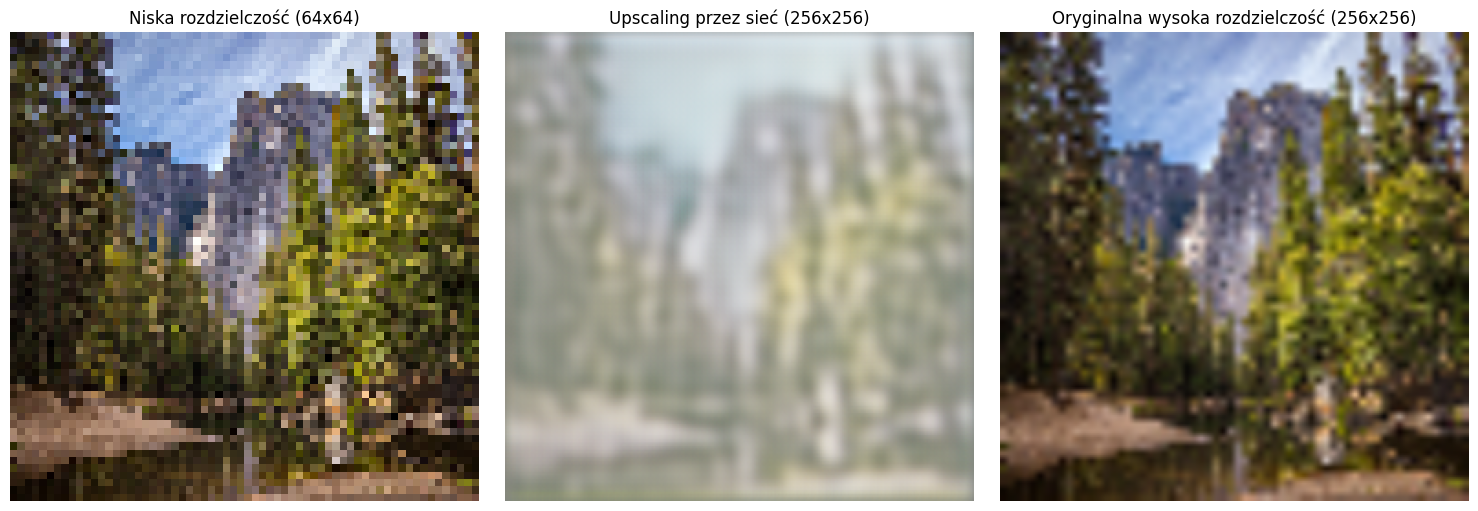

In [35]:
# Testowanie modelu na przykładowym obrazie
test_image_path = "images_64/0007.png"
visualize_results(model, test_image_path, device)